In [3]:
# Import necessary libraries (same as before)
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, GRU, Bidirectional, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load dataset
dataset = pd.read_csv('amazonbinaryclassificationdataset_DL.csv', encoding='latin-1')
print("Dataset loaded.")

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK data downloaded.")

# Preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def clean_text(text):
    if not isinstance(text, str):
        return ""
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    text = strip_html(text)
    text = remove_url(text)
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    return text

# Preprocess text
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [word_tokenize(entry.lower()) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    lemmatizer = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
            Final_words.append(lemma)
    dataset.loc[index, 'text_final'] = str(Final_words)

print("✅ Data preprocessing done.")

# Map labels
dataset['Have_ValueViolation'] = dataset['Have_ValueViolation'].map({'Yes': 1, 'No': 0})

# ——— ✅ STEP 1: SPLIT FIRST (before any resampling!) ———
X_raw = dataset['text_final'].values
y_raw = dataset['Have_ValueViolation'].values

print(f"Original dataset size: {len(X_raw)} | Class dist: {np.bincount(y_raw)}")

# Hold out 15% test (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y_raw, test_size=0.15, random_state=42, stratify=y_raw
)

# Then split remaining 85% into train (70%) & val (15%)
X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Raw train: {len(X_train_raw)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"Train class counts (raw): {np.bincount(y_train_raw)}")
print(f"Test class counts (natural): {np.bincount(y_test)}")

# ——— ✅ STEP 2: Oversample ONLY the training set ———
oversampler = RandomOverSampler(random_state=42)
X_train_res, y_train_res = oversampler.fit_resample(
    X_train_raw.reshape(-1, 1), y_train_raw
)
X_train_res = [x[0] for x in X_train_res]  # flatten to list of strings

print(f"✅ After oversampling → Train size: {len(X_train_res)} | Class counts: {np.bincount(y_train_res)}")

# ——— ✅ STEP 3: Tokenization (fit only on oversampled train) ———
max_words = 1000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_res)

def prepare_sequences(texts, tokenizer, max_len):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

X_train_seq = prepare_sequences(X_train_res, tokenizer, max_len)
X_val_seq = prepare_sequences(X_val, tokenizer, max_len)    # ← natural val
X_test_seq = prepare_sequences(X_test, tokenizer, max_len)  # ← natural test

y_train = y_train_res  # 1D array

print("✅ Sequences prepared.")

# ——— ✅ STEP 4: Define & train BiGRU model ———
def bidirectionalGRUclassifier():
    sequence_input = Input(shape=(max_len,), name='inputs')
    x = Embedding(max_words, 100, input_length=max_len)(sequence_input)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(GRU(8, return_sequences=True, dropout=0.5, recurrent_dropout=0.0))(x)
    x = Conv1D(8, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    preds = Dense(1, activation="sigmoid")(x)
    return Model(inputs=sequence_input, outputs=preds)

model = bidirectionalGRUclassifier()
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train,
    batch_size=100,
    epochs=50,
    validation_data=(X_val_seq, y_val),  # ← val is NOT oversampled!
    callbacks=[early_stop],
    verbose=1
)

# ——— ✅ STEP 5: Final evaluation on natural test set ———
y_pred_proba = model.predict(X_test_seq).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

test_acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Test Accuracy (natural distribution): {test_acc:.4f}")

print("\n📋 Classification Report (Test Set — Natural Distribution):")
print(classification_report(y_test, y_pred, target_names=["No Violation", "Violation"]))

# Optional: Plotting (reuse from earlier)
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Train Acc')
    plt.plot(epochs, val_acc, 'r-o', label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run plotting (uncomment if needed)
    plot_history(history)

<>:47: SyntaxWarning: invalid escape sequence '\['
<>:47: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/33xgrsyx18j1bp7lv_zr_j600000gn/T/ipykernel_36950/34209508.py:47: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')


Dataset loaded.
NLTK data downloaded.


/var/folders/y0/33xgrsyx18j1bp7lv_zr_j600000gn/T/ipykernel_36950/34209508.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


✅ Data preprocessing done.
Original dataset size: 18256 | Class dist: [ 7116 11140]
Raw train: 12778 | Val: 2739 | Test: 2739
Train class counts (raw): [4980 7798]
Test class counts (natural): [1068 1671]
✅ After oversampling → Train size: 15596 | Class counts: [7798 7798]
✅ Sequences prepared.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 150)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 100)  │    100,000 │ inputs[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 150, 100)  │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 150, 16)   │      5,280 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 148, 8)    │        392 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 8)         │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 8)         │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         17 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,689 (412.85 KB)

 Trainable params: 105,689 (412.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


E0000 00:00:1763549359.560618 2800774 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


156/156 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.6217 - loss: 0.6487 - val_accuracy: 0.8021 - val_loss: 0.4219
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - accuracy: 0.8168 - loss: 0.4063 - val_accuracy: 0.8635 - val_loss: 0.3150
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.8631 - loss: 0.3228 - val_accuracy: 0.8726 - val_loss: 0.2974
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8819 - loss: 0.2855 - val_accuracy: 0.8795 - val_loss: 0.2871
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8907 - loss: 0.2640 - val_accuracy: 0.8832 - val_loss: 0.2781
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8989 - loss: 0.2566 - val_accuracy: 0.8916 - val_loss: 0.2702
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9016 - loss: 0.2465 - val_accuracy: 0.8802 - val_loss: 0.2806
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.9079 - loss: 0.2376 - val

E0000 00:00:1763549823.427535 2800774 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

🎯 Final Test Accuracy (natural distribution): 0.9032

📋 Classification Report (Test Set — Natural Distribution):
              precision    recall  f1-score   support

No Violation       0.88      0.87      0.88      1068
   Violation       0.92      0.92      0.92      1671

    accuracy                           0.90      2739
   macro avg       0.90      0.90      0.90      2739
weighted avg       0.90      0.90      0.90      2739



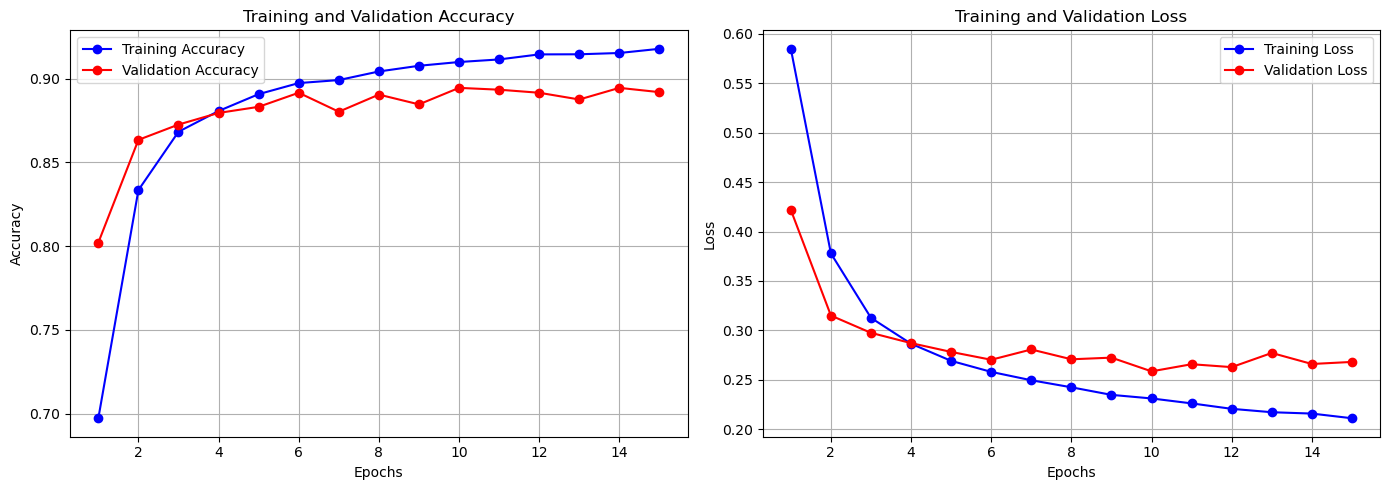

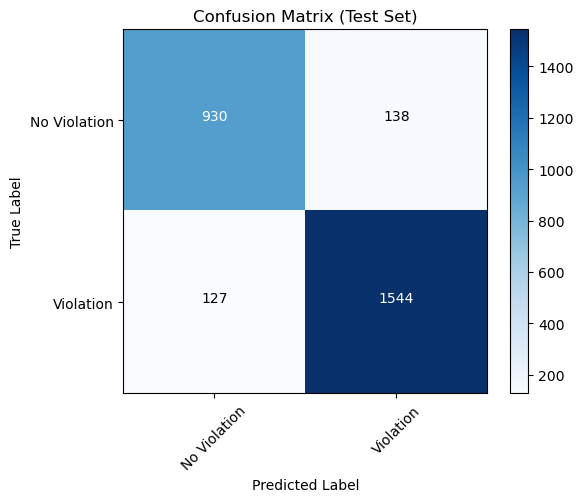

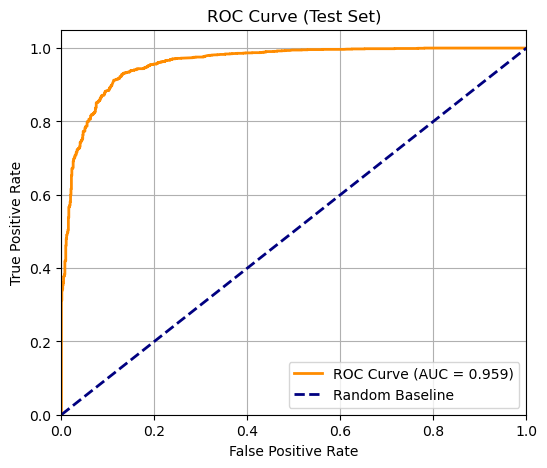

In [4]:
# ——— Plotting ———

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('BiGRU_Training and Validation Loss_Curves.png', dpi=200, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Test Set)")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('BiBRU_Confusion_matrix.png', dpi=200, bbox_inches='tight')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('BiGRU_ROC Curves (One-vs-Rest, Test Set).png', dpi=200, bbox_inches='tight')
    plt.show()

# Generate all plots
plot_history(history)
plot_confusion_matrix(y_test, y_pred, classes=["No Violation", "Violation"])
plot_roc_curve(y_test, y_pred_proba)